# Replacing The COVID Tracking Project data
*Report by Ollie Ballinger*

The best replacement for OWID’s data on hospitalizations and ICU occupancy is the “COVID-19 Reported Patient Impact and Hospital Capacity by State Timeseries”, maintained by the U.S. Department of Health and Human Services (HHS). Alexis Madrigal, founder of the COVID Tracking Project, wrote in an Atlantic article that “the HHS system has become the most reliable source of federal pandemic data.” 

I was able to easily merge the HHS data with OWID’s existing covid database in two simple steps. First, I import the OWID data (df1) and the the HHS data (df2), aggregating df2 across states for each date. 

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
import requests

headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36'}
url="https://covid.ourworldindata.org/data/owid-covid-data.csv"
s=requests.get(url, headers= headers).text

df1=pd.read_csv(StringIO(s), sep=",")
df1=df1[df1['iso_code']=='USA']

df2=pd.read_csv("https://healthdata.gov/sites/default/files/reported_hospital_utilization_timeseries_20210214_1305.csv").groupby('date').sum().reset_index()

Next, I reformat the dates such that both datasets are in the same format (d-m-Y), allowing me to merge the datasets based on date. 

In [7]:
df1['DMY']=pd.to_datetime(df1['date'], infer_datetime_format=True)
df2['DMY']=pd.to_datetime(df2['date'], infer_datetime_format=True)

df3=df1.merge(df2, how='left', on='DMY')
df3=df3[df3['DMY']>'2020-08'].dropna(subset=['DMY','hosp_patients','total_adult_patients_hospitalized_confirmed_covid'])

I define a function that creates a scatterplot using one OWID variable and one HHS variable. Points are colored based on date, and a line of perfect equality is drawn. The Pearson's correlation coefficient is reported as well. 

In [8]:
def plot(x,y,c, xlab, ylab, title):

    R2 = np.corrcoef(x.to_numpy(), y.to_numpy())[1][0]
    print("There is a ", "{:.2%}".format(R2)," correlation between {} and {}".format(xlab, ylab))

    fig, ax = plt.subplots()
    scatter=ax.scatter(x, y, c=c, s=10)

    ax.set(xlabel=xlab,
           ylabel=ylab,
           title=title)
    ax.plot(x, 1 + 1 * x, '-', c='black',label='X=Y')
    ax.legend()

    plt.show()


# How many people are in hospital due to COVID-19 at a given time?

To answer this question, OWID uses data on the total number of COVID patients in hospital (‘hosp_patients’ in the ‘owid-covid-data.csv’ file). I computed an analogous variable using the HHS data by taking the sum of “total_adult_patients_hospitalized_confirmed_covid”, and “total_pediatric_patients_hospitalized_confirmed_covid”.

There is a  99.89%  correlation between OWID COVID Hospital Admissions and HHS COVID Confirmed Hospitalizations (Adult+Pediatric)


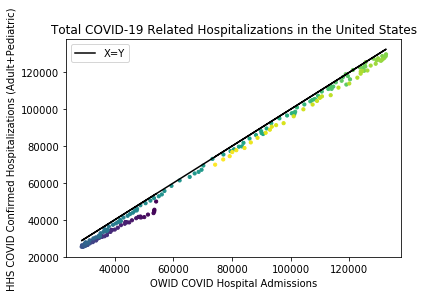

In [9]:
plot(df3['hosp_patients'],
    df3['total_adult_patients_hospitalized_confirmed_covid']+df3['total_pediatric_patients_hospitalized_confirmed_covid'],
    df3['DMY'], 
    "OWID COVID Hospital Admissions", 
    "HHS COVID Confirmed Hospitalizations (Adult+Pediatric)", 
    "Total COVID-19 Related Hospitalizations in the United States")

Color denotes how recent the data are (lighter points are more recent). Discrepancies between the OWID and HHS data were most significant in the early days of the HHS dataset. The black line of equality shows an almost perfect 1:1 relationship between these variables, with the HHS data slightly lower. OWID’s weekly measure of new admissions could be constructed using the “previous_day_admission_adult_covid_confirmed” variable from the HHS dataset. 

# How many people are in intensive care (ICU) due to COVID-19 at a given time?

The variable OWID uses to measure the ICU occupancy in the U.S. is ‘icu_patients’ in the ‘owid-covid-data.csv’ file. The closest corresponding HHS variable is “staffed_icu_adult_patients_confirmed_covid”:

There is a  99.79%  correlation between OWID COVID ICU Admissions and HHS COVID ICU Patients (Adult)


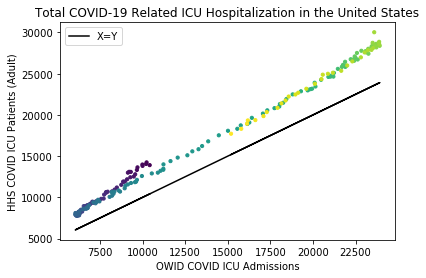

In [11]:
plot(df3['icu_patients'],
    df3['staffed_icu_adult_patients_confirmed_covid'],
    df3['DMY'], 
    "OWID COVID ICU Admissions", 
    "HHS COVID ICU Patients (Adult)", 
    "Total COVID-19 Related ICU Hospitalization in the United States")

Despite the close correlation, the HHS data seems to be slightly higher than the OWID data. This is likely due to the increasing number of hospitals reporting ICU data to the HHS database. 